# Eigenvalue problems

In this notebook we show that quantum mechanics can be easy! Well, at least this sample problem.

Here we solve Schrödinger equation in a symmetrical pit. This is a well-known eigenvalue problem for which we will seek the wave function $\Psi$ that contains all the information about system dynamics.

The problem takes the form:

$$
-\frac{\hbar^2}{2m}\frac{\partial^2\Psi}{\partial{}x^2}+\Psi{}U=E\Psi\implies
\left[-\frac{\hbar^2}{2m}\frac{\partial^2}{\partial{}x^2}+U\right]\Psi=E\Psi
$$

To solve it we provide function `symmetric_pit1d` which computes the approximate version of the operator acting over $\Psi$.

In [1]:
import numpy as np
import scipy.sparse as sparse
import scipy.sparse.linalg as linalg
import matplotlib.pyplot as plt
%matplotlib inline

First we create a discrete formulation of the problem through the implementation of `symmetric_pit1d`.

In [2]:
def symmetric_pit1d(m, length, N):
    """ Discretize with FDM a symmetric pit problem. """
    # Plank constant h/2pi [J.s].
    hbar = 1.05457e-34
    
    # Problem multiplier.
    p = -hbar ** 2 / (2 * m)
    
    # Space discrete step [m].
    dx = length / N
    
    # Discretize space.
    x = np.linspace(-dx, length + dx, N)
    
    # Pit potential [J].
    U = np.zeros(N)
    
    # Boundary potential is `infinite`.
    U[0] = U[-1] = np.inf
    
    # Create matrix.
    M = sum((np.diagflat(-p / dx ** 2 * np.ones(N - 1), +1),
             np.diagflat([U + 2 * p / dx ** 2], 0),
             np.diagflat(-p / dx ** 2 * np.ones(N - 1), -1)))
    return x, sparse.csc_matrix(M)

Now we simply use this function to generate the numerical approximation to the QM operator and with help of `eigsh` we retrieve the first 3 eigenvectors close to zero.

In [3]:
# Electron mass [kg].
m = 9.10938e-31

# Pit width [m].
L = 1.0e-06

# Create problem matrix.
x, M = symmetric_pit1d(1000 * m, L, 5000)
d, V = linalg.eigsh(M, k=3, sigma=0.0)

To make $\Psi$ interpretable as a probability density we take the normalized square of its value.

In [4]:
def norm(v):
    """ Compute the norm of PDF `v`. """
    n = np.conj(v) * v
    a = np.trapz(n, x)
    return n / a
    
tup = [(d[i], 1.0e-06 * norm(V[:,i])) for i in range(3)]
tup = sorted(tup, key=lambda p: abs(p[0]))

Finally we can get to the visualization of solution.

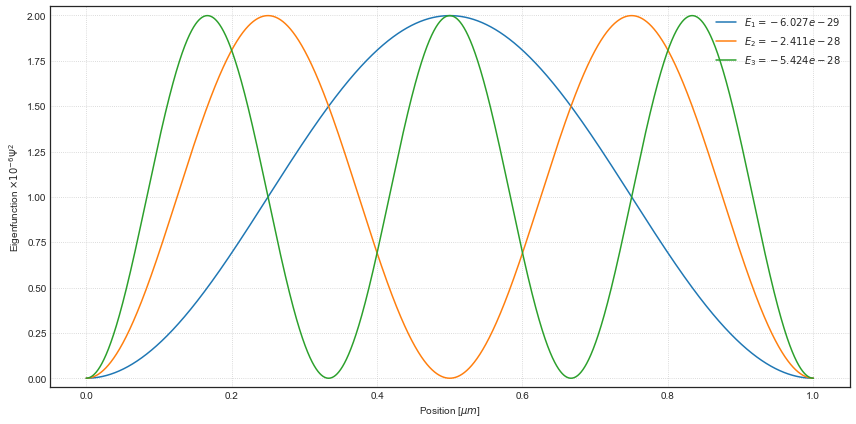

In [5]:
plt.close("all")
plt.style.use("seaborn-white")
plt.figure(figsize=(12, 6))

for i, (E, psi) in enumerate(tup):
    plt.plot(x * 1.0e+06, psi, label=F"$E_{i+1}={E:.3e}$")
   
plt.grid(linestyle=":")
plt.legend(loc=1)
plt.ylabel("Eigenfunction $\\times{}10^{-6} \\Psi^2$")
plt.xlabel("Position [$\\mu{}m$]")
plt.xlim(-0.05, 1.05)
plt.ylim(-0.05, 2.05)
plt.tight_layout()

With this knowledge we can explore other possible configurations. Next we provide the implementation of a potential barrier separating two low pontential pits.

In [6]:
def get_discrete_schrodinger(L, U, N):
    """ Create matrix for tunneling problem.
    
    Parameters
    ----------
    L : float
        Width of region to be evaluated.
    U : Callable[[float], float]
        Potential function for constructing pit.
    N : int
        Number of discrete cells in region
        
    Returns
    -------
    Tuple[List[float], sparse.csc_matrix]
        Position coordinates array and problem matrix.
    """
    x, dx = np.linspace(-L / 2, L / 2, N, retstep=True)

    M = sum((np.diagflat(-1 / dx ** 2 * np.ones(N - 1), +1),
             np.diagflat([U(x) + 2 / dx ** 2], 0),
             np.diagflat(-1 / dx ** 2 * np.ones(N - 1), -1)))

    return x, sparse.csc_matrix(M)

In [7]:
def potential(x, L, w, H):
    """ Create matrix for tunneling problem.
    
    Parameters
    ----------
    x : List[float]
        Position coordinates array.
    L : float
        Width of region to be evaluated.
    w : float
        Fraction of region where potential is `H`.
    H : float
        Potential spliting pit into zones.
        
    Returns
    -------
    List[float]
        Potential evaluated in space.
    """
    U = H * np.ones_like(x)

    W = L * (1 - w)
    U[x < -(L - W) / 2] = 0
    U[x > +(L - W) / 2] = 0
    
    U = H * U / U.max()
    U[0] = U[-1] = H

    return U

In [8]:
def post_process(x, U, d, V):
    """ Create matrix for tunneling problem.
    
    Parameters
    ----------
    x : List[float]
        Position coordinates array.
    U : Callable[[float], float]
        Potential function for constructing pit.
    d : List[float]
        Array of eigenvalues.
    V : List[List[complex]]
        Matrix of eigenvectors.
    """
    def norm(v):
        v = v * np.conj(v)
        return v / np.trapz(v, x)

    tup = sorted([(di, norm(V[:,i])) for i, di in enumerate(d)],
                 key=lambda p: p[0])

    plt.close("all")
    plt.style.use("seaborn-white")
    plt.figure(figsize=(12, 6))
    
    plt.subplot(211)
    plt.plot(x, U(x))
    plt.grid(linestyle=":")
    plt.ylabel("Potential $U$")
    plt.xlabel("Position $x$")
    
    plt.subplot(212)
    for i, (E, psi) in enumerate(tup):
        plt.plot(x, psi, label=F"$E_{i+1}={E:.6e}$")
        
    plt.grid(linestyle=":")
    plt.legend(loc=1, frameon=True, framealpha=0.9)
    plt.ylabel("Eigenfunction $\\Psi^2$")
    plt.xlabel("Position $x$")

    plt.tight_layout()

Below you find the previous functions in action. By increasing the potential height `H` one can observe the appearance of degenerated state that tunnel between the two sides of the barrier. You can uncomment the line setting logscale in y-axis to confirm the tunneling. Notice that above a certain threshold of about $H\ge{}10^6$ the value of $\Psi^2$ inside the barrier stops decreasing and remains in the order of $10^{-30}$.

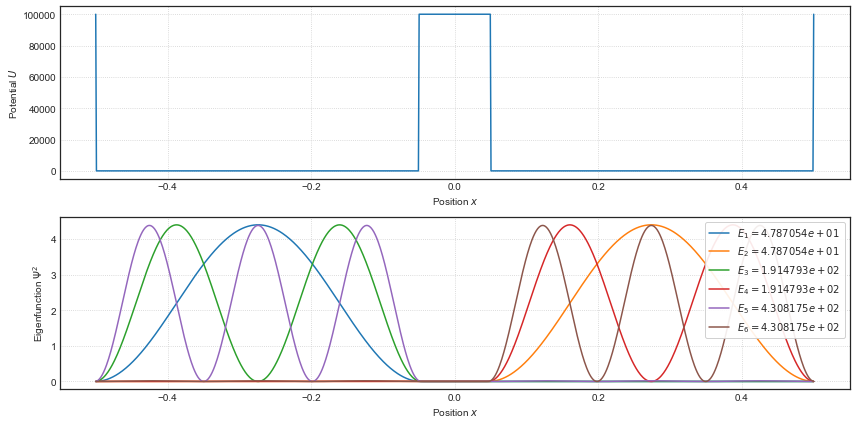

In [9]:
L = 1.0
w = 0.1
H = 1.0e+05
U = lambda x: potential(x, L, w, H)

x, M = get_discrete_schrodinger(L, U, 1000)
d, V = linalg.eigsh(M, k=6, sigma=0.0)

post_process(x, U, d, V)
# plt.yscale("log")